# **Generative Adversarial Networks (GANs) - Hands-on Exercise**
This exercise will guide you through building and training a simple Generative Adversarial Network (GAN) using TensorFlow. GANs are a powerful class of deep learning models that can generate new data resembling the training data.

## **Learning Objectives:**

* Understand the core concepts of GANs (Generator and Discriminator).
* Implement a DCGAN (Deep Convolutional GAN) architecture in TensorFlow.
* Train the GAN model on a dataset of images.
* Visualize the generated images during training.

## **Prerequisites:**

* Basic understanding of Python programming.
* Familiarity with Machine Learning and Deep Learning concepts.



## **1: Setting Up the Environment**

In [ ]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.datasets import mnist # handwritten digits from classification lesson 2
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape, LeakyReLU
from tensorflow.keras.models import Sequential

# Load MNIST dataset (handwritten digits)
(train_images, _), (_, _) = mnist.load_data() # loading mnist data and only keep train_images to supply ground truth to discriminator

# Preprocess data (normalize pixel values to range [0, 1])
train_images = train_images.reshape(-1, 28, 28, 1)
train_images = train_images.astype('float32') / 255.0 # standardization pixels to be within 0-1

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### **Explanation:**

1. We import necessary libraries: TensorFlow for deep learning operations, mnist dataset for handwritten digits, and Keras layers for building neural networks.
  - `Dense`, `Conv2D`, etc., to build Generator and Discriminator.
  - `Conv2DTranspose` is for upsampling (used in the Generator).
  - `LeakyReLU` is a common activation in GANs to avoid dying neurons.
2. We load the MNIST dataset, separating training images from labels (which we won't use in this exercise).
  - Typically we would load as (train_images, train_labels), (test_images, test_labels) = mnist.load_data() to unpack the tuples into training and testing images with their corresponding labels.
  - In this case, we use `_` to still unpack all the tuples from the dataset, but only keep `train_images`, while discarding the rest, because we only need training images for GAN training.
3.  We reshape the images to include a channel dimension (as our model expects colored images that come in 3 channels).
  - CNN expects input in this format: (number of images, image height, image width, number of channels)
  - `reshape(-1,...)`: This is a shortcut that tells Python, "Figure this out for me based on the total number of images."
  - `reshape(..,28, 28,...)`: height and width of each image — the Fashion-MNIST dataset has 28×28 pixel grayscale images.
  - `reshape(...,1)`: number of color channels - 1 = grayscale (black & white) and 3 = RGB color image. Note that our dataset is grayscale images.
4. Finally, we normalize pixel values to the range of 0 to 1, a common practice for image data.

## **2: Building the GAN Model**

In [ ]:
# Define the Generator model
def build_generator(): # python function: def func_name(arguments):
    model = Sequential() # Start building a sequential model
    model.add(Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')) # deconv
    model.add(Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same'))
    model.add(Conv2DTranspose(1, (3, 3), activation='tanh', padding='same'))
    return model # function ends with what to output when the function is called defined by "return"

# Define the Discriminator model
def build_discriminator(image_shape):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=image_shape, activation=LeakyReLU(alpha=0.2))) # conv layer 1 with 64 nodes & 3x3 kernel
    model.add(Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.2))) # conv layer 2 with 128 nodes &  3x3 kernel
    model.add(Flatten()) # flatten to 1D vector to attach to FFNN
    model.add(Dense(1, activation='sigmoid')) # output layer
    return model

# Create the Generator and Discriminator models
generator = build_generator() # function call/invoke build_generator() and assign model to generator
discriminator = build_discriminator((28, 28, 1)) # function call/invoke build_discriminator() and assign model to generator

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### **Explanation:**

1. We define two separate functions to build the Generator and Discriminator models.
2. **Generator:** - Its job is to take random noise as input and generate a 28×28 image that looks like a handwritten digit.
    * `model = Sequential()` - Start building a model where layers are added one after another.
    * `model.add(Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))` - Take a random vector of size 100 (noise) and map it into a larger flat vector of length 7 x 7 x 256 = 12,544 values — imagine stretching the noise into something shaped like a rough 7×7 (height x width) image with 256 channels.
      - The input vector size of 100 here is arbitary, but widely used because it's big enough to hold diverse information, yet small enough to compute efficiently.
      - The output of this layer is a flat vector of size 12,544, which will then be reshaped into a 3D tensor.
    * `model.add(Reshape((7, 7, 256)))` - Reshape that long vector into a 3D block of shape 7 × 7 × 256, which is like a small, deep image.
      - Why these dimensions?
        - The goal is to eventually generate 28x28 size images for the MNIST digits, so starting with a smaller “seed image” (7 × 7) and then doubling the size twice using Conv2DTranspose layers: 7×7 → 14×14 → 28×28
        - 256 is the number of channels — think of it like the depth of the image, where more channels allow the network to learn more features.
        - Channels are "feature layers". In normal color images, there are 3 channels - Red (R), green (G), Blue (B).
        - But in neural networks: More channels = more capacity to store learned features. Each channel learns different aspects of the image (e.g., edges, curves, textures)
        - There can be a different number as well, not strictly 256. Just be aware of trade-offs - if we chose higher channels, e.g., 512, we'll have room for more detailed features, better quality — but slower and heavier. Similarly, if the channels were lower, e.g., 128 or 64, we may lose detail, but achieve higher speeds

  * First 2 `Conv2DTranspose` - The first 2 `Conv2DTranspose()` layers are used to upsample the image — that means increasing its height and width step by step, like zooming in but with learned detail added.
    - With every `stride=2` in a transpose convolution (also called deconvolution), a stride of 2 means: “Expand the spatial size (height and width) by 2×.” This is opposite to normal convolution where increasing stride would shrink output image vector. In below image, we can see how an input image has doubled its size after Transposed Convolution with stride 2. So, after these 2 `Conv2DTranspose` layers, the output image size doubles from 7×7 → 14×14 → 28×28
    ![](https://media.geeksforgeeks.org/wp-content/uploads/20230110162532/Transposed-Convolutional-2.png)
    - padding='same' - Keeps the image size exactly what the stride wants — no cropping or shrinking.
    - The first `Conv2DTranspose` layer outputs 128 layers/features while the next does 64. (3,3) in both cases is the Kernel size used when applying upsampling. These numbers are hyperparameters and can be changed. Though, for the design we're keeping it intentional to start off with more channels, 128 (to learn more complex features) followed by 64 as we closer to the output.
    - `activation='relu'` -	Helps the model learn complex patterns.
 * Last `Conv2DTranspose` `model.add(Conv2DTranspose(1, (3, 3), activation='tanh', padding='same'))`
    - `Conv2DTranspose(1,..)`: Number of output channels, because our image is in grayscale with just 1 channel
    - `Conv2DTranspose(..,(3,3)`: Still the kernel (also called a filter) size. Since no stride is specified, it's value defaults to 1 and this layer of `Conv2DTranspose` does _not_ upsample since we already reached the target size (28×28) from the previous 2 layers
    - `tanh` activation: Used here because It outputs values between -1 and 1 which matches the normalized pixel range often used in GANs. It helps stabilize training and makes the final image sharper and more centered around zero

3. **Discriminator:** - Its job is to take a 28×28 image and decide: is it real or fake?
    * Takes an image (28x28) grayscale/1 channel as input.
    * Uses convolutional layers to do downsampling - extract features from the image. `LeakyReLU` activation function allows small gradients even for negative values — helps avoid dead neurons.
    * Note that in the `Conv2D` layers here, we start simple: 64 filters to detect things like edges, blobs. Then go deeper: 128 filters learn higher-level features like shapes or digit structure.
    * Flattens the 3D feature map into a 1D vector, so it can be passed into a fully connected (Dense output) layer.
    * Final output with sigmoid activation classifies the image as real (1) or fake (0).

## **3: Defining Loss Functions and Optimizers**

In [ ]:
# Define loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # Compare the model’s prediction on real images to what it should be: 1 (real).
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # Compare the model’s prediction on fake images to what it should be: 0 (fake).
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) # Measures how far Generator's fake_output/image is from 1

# Define Optimizers
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)

### **Explanation:**

* `discriminator_loss`:

    * Calculates the 'real loss' by comparing the discriminator's output on real images to a 'target' of all ones (since real images should be classified close to 1).
    * Calculates the 'fake loss' by comparing the discriminator's output on generated (fake) images to a 'target' of all zeros.
    * Returns the total loss, which is the sum of the 'real loss' and 'fake loss'.
    * Note that `tf.ones_like(real_output)` returns a tensor (array) of __1s__ that has the same shape as real_output, similarly tf.zeros_like(fake_output) returns __0s__

* `generator_loss`:

    * Calculates the loss for the generator by comparing the discriminator's output on the generated (fake) images to a 'target' of all ones. The generator wants the discriminator to believe its fake images are real.
      - If the Discriminator gives 0.2 (means “I think it's fake”), the Generator gets a high loss — because it failed to fool the Discriminator.
      - If the Discriminator gives 0.9 (means “I think it’s real”), the Generator gets a low loss — great job fooling it!

* `generator_optimizer`, `discriminator_optimizer`:

    * We use the Adam optimizer for updating weights in both the generator and discriminator. The parameters (learning rate, etc.) can be fine-tuned for optimal training.
      - `learning_rate=1e-4` means "learn slowly" (0.0001) — helps stability
      - `beta_1=0.5` is a GAN-specific trick that helps reduce model instability.

### **Key Points**

* **Binary Crossentropy Loss:** This loss function is well-suited for tasks where the output is a probability between 0 and 1 (like the discriminator trying to predict if an image is real or fake).

## **4: Training the GAN**

In [ ]:
# Hyperparameters
batch_size = 128 # Number of images processed at once
noise_dim = 100 # Size of the random noise input for the Generator
epochs = 10  # How many times to loop through the dataset. Adjust for longer training if needed

In [ ]:
# Training loop repeated for each epoch (one full pass through the data)
for epoch in range(epochs):
    # Take all training images from train_images, break them into batches of size 128 (based on batch_size definition above)
    # Loop through those batches with a loop counter batch_idx generated by enumerate
    # We do it this way because in GANs, this is not handled conveniently for us within model.fit() of standard NN

    for batch_idx, real_images in enumerate(tf.data.Dataset.from_tensor_slices(train_images).batch(batch_size)):

        ## Train the Discriminator

        # Step 1: Generate random noise of shape (128, 100) to generate 128 images at once, each with length 100
        noise = tf.random.normal([batch_size, noise_dim])

        # Step 2: Pass the noise through the Generator function to create fake images
        fake_images = generator(noise)

        # Step 3: # Use GradientTape to track operations during forward pass
        # So we can calculate gradients and update weights during backpropagation
        with tf.GradientTape() as d_tape:
            real_output = discriminator(real_images, training=True) # Discriminator predicts on real images (should say 1)
            fake_output = discriminator(fake_images, training=True)  # Discriminator predicts on fake images from the Generator (should say 0)
            d_loss = discriminator_loss(real_output, fake_output) # Compute total loss for the Discriminator (real should be 1, fake should be 0)

        # Step 4: Calculate gradients and apply updates to the Discriminator
        d_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))
        # --------------------------------------------------------------------------------------------------

        ## Train the Generator

        # Step 1: Generate a new batch of noise
        noise = tf.random.normal([batch_size, noise_dim])

        # Step 2: Use GradientTape to track operations during forward pass
        # So we can calculate gradients and update weights during backpropagation
        with tf.GradientTape() as g_tape:
            fake_images = generator(noise, training=True) # Generate fake images from the new noise
            fake_output = discriminator(fake_images, training=False) # Pass the fake images to the Discriminator (which is now fixed for this step)
            g_loss = generator_loss(fake_output) # Calculate Generator loss (how well it fooled the Discriminator)

        # Step 3: Calculate gradients and apply updates to the Generator
        g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))

        # Print progress every 100 batches
        # For out dataset of 60k samples and batch size set to 128, we see until Batch 400 because of 60k/128 ~468 batches per epoch
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Batch: {batch_idx}, Discriminator Loss: {d_loss:.4f} Generator Loss: {g_loss:.4f}')

Epoch [1/10], Batch: 0, Discriminator Loss: 1.3763 Generator Loss: 0.6918
Epoch [1/10], Batch: 100, Discriminator Loss: 0.6679 Generator Loss: 1.5600
Epoch [1/10], Batch: 200, Discriminator Loss: 0.5680 Generator Loss: 1.4663
Epoch [1/10], Batch: 300, Discriminator Loss: 0.5838 Generator Loss: 1.4959
Epoch [1/10], Batch: 400, Discriminator Loss: 0.8100 Generator Loss: 1.2479
Epoch [2/10], Batch: 0, Discriminator Loss: 0.7861 Generator Loss: 0.8845
Epoch [2/10], Batch: 100, Discriminator Loss: 0.8646 Generator Loss: 1.5800
Epoch [2/10], Batch: 200, Discriminator Loss: 0.8627 Generator Loss: 1.3078
Epoch [2/10], Batch: 300, Discriminator Loss: 0.8023 Generator Loss: 1.3255
Epoch [2/10], Batch: 400, Discriminator Loss: 1.0083 Generator Loss: 1.4397
Epoch [3/10], Batch: 0, Discriminator Loss: 0.9690 Generator Loss: 0.7383
Epoch [3/10], Batch: 100, Discriminator Loss: 0.7729 Generator Loss: 1.1870
Epoch [3/10], Batch: 200, Discriminator Loss: 0.8106 Generator Loss: 1.0989
Epoch [3/10], Batc

### **Explanation:**

We dive into the core training process of our Generative Adversarial Network (GAN). Here, we'll witness the fascinating interplay between the generator and discriminator as they strive to improve their abilities.

**The Training Loop:**

The training involves an iterative process through epochs (full passes through the training data). Within each epoch, we iterate through batches of the MNIST dataset. Here's what happens during each iteration (batch):

1. **Train the Discriminator:**

    * **Generate Fake Images:** We use the generator to create a batch of fake images based on random noise input.
    * **Calculate Discriminator Loss:** We calculate the loss for the discriminator on two sets of images:
        * **Real Images:** The discriminator tries to classify real MNIST digits (labeled as close to 1).
        * **Fake Images:** The discriminator tries to classify the generated fake images (labeled as close to 0).
    * **Update Discriminator:** We use the calculated loss to update the weights of the discriminator through backpropagation, aiming to make it better at distinguishing real from fake images.

2. **Train the Generator:**

    * **Generate Fake Images (Again):** Similar to step 1, we generate a batch of fake images using the generator.
    * **Calculate Generator Loss:** We calculate the loss for the generator based on how well it can fool the discriminator. Ideally, the generator wants the discriminator to believe its fake images are real (labeled close to 1).
    * **Update Generator:** We use the generator loss to update the weights of the generator through backpropagation, aiming to make it better at creating images that resemble real MNIST digits.

**Key Points:**

* This adversarial training process creates a competition where the generator and discriminator continuously push each other's boundaries.
* The discriminator loss encourages the discriminator to become a better classifier of real vs. fake images.
* The generator loss encourages the generator to produce more realistic-looking fake images.
* Over multiple epochs, the generator gradually improves its ability to generate high-quality images that can deceive the discriminator.

**Additional Considerations:**

* Hyperparameter Tuning: Learning rates, batch sizes, and optimizer choices can significantly impact training performance. Experimentation might be needed to find the optimal settings.

## **5: Generating New Digits**

In [ ]:
# Hyperparameters
noise_dim = 100

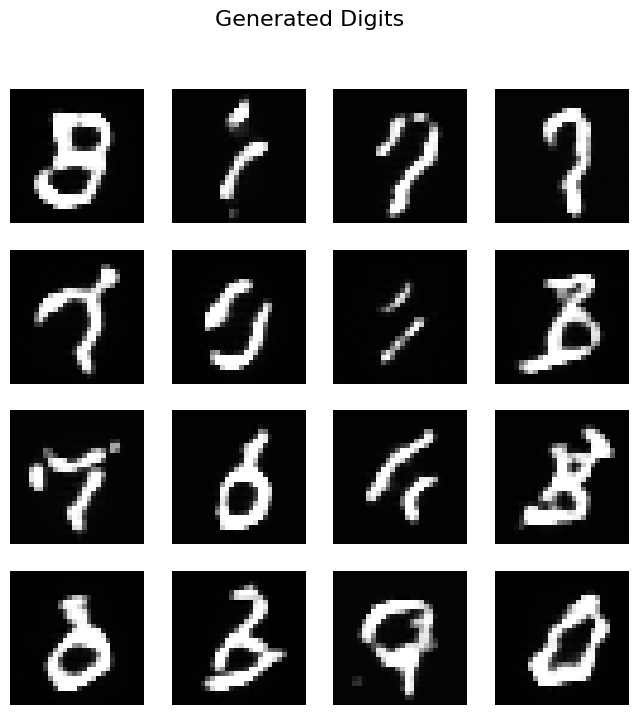

In [ ]:
import matplotlib.pyplot as plt

# Generate new images
num_images_to_generate = 16 # create 16 fake images
noise = tf.random.normal([num_images_to_generate, noise_dim]) # use TensorFlow library (tf) to create a bunch of random numbers.
# The normal part means these numbers will follow a "normal distribution" (also known as a bell curve), which is a common way to generate random numbers
generated_images = generator(noise, training=False) # training=False to run inference, not training. we follow this setting AFTER  training

# Visualize generated images
plt.figure(figsize=(8, 8)) # sets the size for the entire canvas
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i+1) # create and select a specific "subplot" within the larger figure that was created with plt.figure()
    # (4, 4, i+1) creates a 4x4 rowxcol grid, select (i+1)-th position in that 4x4 grid.
    # The loop variable i goes from 0 to 15, so i+1 goes from 1 to 16, ensuring each of the 16 images gets its own spot in the grid

    plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray') # main command to display an image in the currently selected subplot
    # :, :, 0: Selects all rows and all columns of the image, and specifically takes the first (and only) channel (0) since it's a grayscale image.
    # * 127.5 + 127.5: This part is crucial for displaying the image correctly. Remember that the generator's output uses a tanh activation, which produces pixel values between -1 and 1.
    # Image display functions typically expect pixel values in the range of 0 to 255 (for 8-bit grayscale). This calculation scales the values from the [-1, 1] range to the [0, 255] range
    # Multiplying by 127.5 scales the range from [-1, 1] to [-127.5, 127.5].
    # Adding 127.5 shifts the range from [-127.5, 127.5] to [0, 255].
    # cmap='gray': This specifies that the image should be displayed in grayscale colors.

    plt.axis('off') # urns off the axes (the numbers and tick marks) to make the grid look cleaner
plt.suptitle("Generated Digits", fontsize = 16)
plt.show()

### **Explanation:**

1. **Generate Noise:** We create a random noise vector, which serves as input to the generator.
2. **Generate Images:** The trained `generator` model is called with this `noise` to produce new images using the `training=False` parameter to use the generator's inference mode.
3. **Visualize:** We display the generated images in a grid. You should see a grid of newly generated handwritten digits!

### **Important Notes:**

* **Quality:** The quality of the generated images depends on how well your GAN has been trained. If they still seem blurry or distorted, you might want to continue training your GAN for more epochs.
* **Randomness:** Each time you run this code, you'll get a different set of generated digits due to the random noise input.